In [ ]:
#@title {vertical-output: true}

#============================================================
#INSTALLS & IMPORTS

!pip install pyreadstat
import pandas as pd
import numpy as np
import pyreadstat
import requests
from collections import defaultdict
import statsmodels.api as sm
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler

#============================================================
#VARIABLES

#changeBelowLink
url = "https://github.com/maxwell-petitjean/regression/raw/refs/heads/main/brand_tracking_test.sav"

#Download the file
response = requests.get(url)
with open("brand_tracking_test.sav", "wb") as f:
    f.write(response.content)

#read SPSS file
df, meta = pyreadstat.read_sav("brand_tracking_test.sav")


In [ ]:
#check shape
print(df.shape)

(1032, 1476)


In [ ]:
#@title {vertical-output: true}
#see cols - vertical
pd.set_option("display.max_rows", None)
print(df.iloc[0])

ResponseID                                     207348029.0
RespondentID                                   229229999.0
Intro_Consent                                          NaN
Intro_Consent_Age                                      NaN
dCountry                                               8.0
Wave                                                   1.0
Gender                                                 2.0
dGender                                                2.0
AGE_1                                                 20.0
dAgeBand                                               1.0
Q1_1                                                   1.0
Q1_2                                                   0.0
Q1_3                                                   1.0
Q1_4                                                   0.0
Q1_5                                                   1.0
Q1_97                                                  0.0
Q1_99                                                  0

In [ ]:
#check all columns
pd.set_option("display.max_columns", None)
print( df.head(4) )

    ResponseID  RespondentID  Intro_Consent  Intro_Consent_Age  dCountry  \
0  207348029.0   229229999.0            NaN                NaN       8.0   
1  207348083.0   229230053.0            NaN                NaN       8.0   
2  207348318.0   229230287.0            NaN                NaN       8.0   
3  207348393.0   229230362.0            NaN                NaN       8.0   

   Wave  Gender  dGender  AGE_1  dAgeBand  Q1_1  Q1_2  Q1_3  Q1_4  Q1_5  \
0   1.0     2.0      2.0   20.0       1.0   1.0   0.0   1.0   0.0   1.0   
1   1.0     2.0      2.0   23.0       1.0   1.0   1.0   0.0   1.0   1.0   
2   1.0     1.0      1.0   26.0       2.0   1.0   1.0   1.0   1.0   1.0   
3   1.0     2.0      2.0   30.0       2.0   1.0   0.0   0.0   1.0   1.0   

   Q1_97  Q1_99  Q2_1  Q2_2  Q2_3  Q2_4  Q2_5  Q2_6  Q2_7  Q2_8  Q2_9  Q2_98  \
0    0.0    0.0   1.0   0.0   1.0   0.0   0.0   0.0   0.0   0.0   0.0    0.0   
1    0.0    0.0   1.0   1.0   1.0   0.0   1.0   0.0   1.0   0.0   0.0    0.0   
2  

In [ ]:
#tidy up column names
df2 = df.copy()

#rename columns so that we can easily pick columns next
df2 = df2.rename(columns=lambda c: c.replace("BRANDBUYER_", "brand-", 1) if "BRANDBUYER" in c else c)
df2 = df2.rename(columns=lambda c: c.replace("__", "_", 1) if "__" in c else c)
df2 = df2.rename(columns=lambda c: c.replace("ResponseID", "qq_id", 1) if "ResponseID" in c else c)
df2 = df2.rename(columns=lambda c: c.replace("Gender", "qq_gender", 1) if "Gender" in c else c)
df2 = df2.rename(columns=lambda c: c.replace("AGE_1", "qq_age", 1) if "AGE_1" in c else c)
df2 = df2.rename(columns=lambda c: c.replace("dAgeBand", "qq_age_group", 1) if "dAgeBand" in c else c)

#only columns that start with
df2 = df2.loc[:, df2.columns.str.startswith(("Q","qq_","brand"))]

#columns to remove **based on strings i dont know what to do with
remove_strings = ["trans","DK","Other"]
df2 = df2.loc[:, ~df2.columns.str.contains("|".join(remove_strings))]


df3 = df2.copy()


In [ ]:
#@title {vertical-output: true}
#see all cols now
pd.set_option("display.max_rows", None)
print(df3.iloc[0])

qq_id                  207348029.0
qq_gender                      2.0
qq_age                        20.0
qq_age_group                   1.0
Q1_1                           1.0
Q1_2                           0.0
Q1_3                           1.0
Q1_4                           0.0
Q1_5                           1.0
Q1_97                          0.0
Q1_99                          0.0
Q2_1                           1.0
Q2_2                           0.0
Q2_3                           1.0
Q2_4                           0.0
Q2_5                           0.0
Q2_6                           0.0
Q2_7                           0.0
Q2_8                           0.0
Q2_9                           0.0
Q2_98                          0.0
Q2_99                          0.0
Q3                             3.0
Q4_1                      gymshark
Q4_2                        adidas
Q4_3                          nike
Q4_4                              
Q4_5                              
Q4_6                

In [ ]:
#go have a look at the pre-post cleaning
print("Before:", df.shape)
print("After :", df3.shape)


Before: (1032, 1476)
After : (1032, 1089)


In [ ]:
df4 = df3.copy()

#outcome variable
OUTCOME_COL = "Q10_1"
y = df4[OUTCOME_COL].astype(float)


#build predictor
X = df4.drop(columns=[OUTCOME_COL])

#numeric columns only
X = X.select_dtypes(include=["number"])

#drop columns **could add more here
X = X.drop(columns=["qq_id"], errors="ignore")

#clean nulls
X = X.fillna(0)
y = y.fillna(y.mean())

#run ols
X_const = sm.add_constant(X)
model = sm.OLS(y, X_const)
result = model.fit()

print(result.summary())



                            OLS Regression Results                            
Dep. Variable:                  Q10_1   R-squared:                       0.967
Model:                            OLS   Adj. R-squared:                  0.681
Method:                 Least Squares   F-statistic:                     3.384
Date:                Thu, 18 Dec 2025   Prob (F-statistic):           2.80e-13
Time:                        16:54:26   Log-Likelihood:                -1178.9
No. Observations:                1032   AIC:                             4206.
Df Residuals:                     108   BIC:                             8770.
Df Model:                         923                                         
Covariance Type:            nonrobust                                         
                          coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------------
qq_gender               0.1077    

In [ ]:
#standardise X and y
scaler_X = StandardScaler()
scaler_y = StandardScaler()

X_std = scaler_X.fit_transform(X)
y_std = scaler_y.fit_transform(y.values.reshape(-1, 1)).ravel()

#intercept
X_std_const = sm.add_constant(X_std)

#refit with intercept
std_model = sm.OLS(y_std, X_std_const)
std_result = std_model.fit()

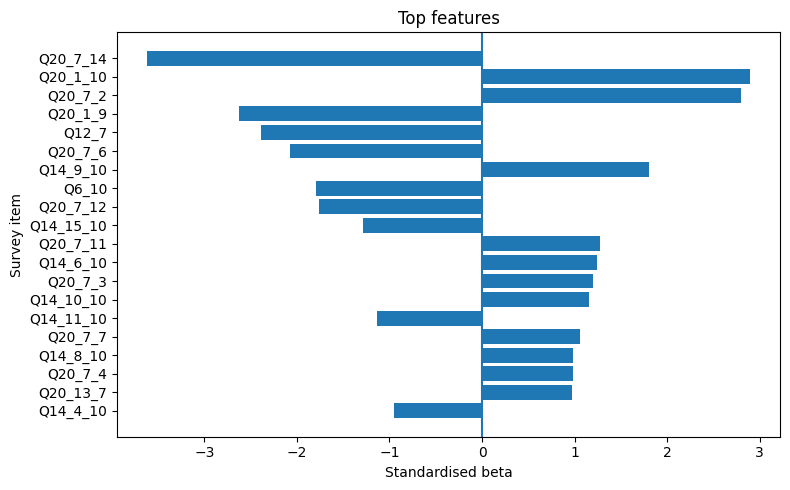

In [ ]:
#feature impacts
feature_df = pd.DataFrame({
    "variable": X.columns,
    "beta": std_result.params[1:]  # drop intercept
})

feature_df["abs_beta"] = feature_df["beta"].abs()

#top features
TOP_N = 20
top_feature = feature_df.sort_values("abs_beta", ascending=False).head(TOP_N)

#plot
plt.figure(figsize=(8, 5))
plt.barh(
    top_feature["variable"],
    top_feature["beta"]
)
plt.axvline(0)
plt.gca().invert_yaxis()
plt.title("Top features")
plt.xlabel("Standardised beta")
plt.ylabel("Survey item")
plt.tight_layout()
plt.show()
